## Glue gsynet (predictive coding network) to crcns data with feature-weighted rf model

In [4]:
version_number =  '0p1'

In [1]:
import numpy as np
import pandas as pd
import h5py
import pickle
import matplotlib.pyplot as plt
from time import time
from glob import glob
from scipy.io import loadmat
from PIL import Image
from scipy.stats import pearsonr
from hrf_fitting.src.feature_weighted_rf_models import make_rf_table,receptive_fields, model_space, prediction_menu,bigmult
from hrf_fitting.src.feature_weighted_rf_models import train_fwrf_model
from hrf_fitting.src.gabor_feature_dictionaries import gabor_feature_maps
from os.path import join

Using gpu device 0: GeForce GTX TITAN X


In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

### Step 0: Load crcns-gsynet feature maps

In [ ]:
##known stimulus parameters
Ttrn = 1750
Tval = 120

##don't use these
junk_keys = ['__header__', '__globals__', '__version__', 'fc6', 'fc7', 'fc8','prob']

##this is > 8GB
deepnet_trn_feature_dict = loadmat('/media/tnaselar/Data/predicive_coding_1/pc1_vim-1_trn_response.mat')
##it contains some key/value pairs we don't want

deepnet_trn_feature_dict = {key: value.astype('float32') for key, value in deepnet_trn_feature_dict.items() if key not in junk_keys}
print deepnet_trn_feature_dict.keys()

##much smaller
deepnet_val_feature_dict = loadmat('/media/tnaselar/Data/predicive_coding_1/pc1_vim-1_val_response.mat')
##it contains some key/value pairs we don't want
deepnet_val_feature_dict = {key: value.astype('float32') for key, value in deepnet_val_feature_dict.items() if key not in junk_keys}
print deepnet_val_feature_dict.keys()


for these inputs we need to put the feature-depth upfront

In [ ]:
for kk in deepnet_trn_feature_dict.keys():
    deepnet_trn_feature_dict[kk] = np.swapaxes(deepnet_trn_feature_dict[kk][:,np.newaxis,:,:,:], 4,1).squeeze()
    
for kk in deepnet_val_feature_dict.keys():
    deepnet_val_feature_dict[kk] = np.swapaxes(deepnet_val_feature_dict[kk][:,np.newaxis,:,:,:], 4,1).squeeze()
    

### Step 2: receptive fields

In [ ]:
deg_per_stimulus = 20
deg_per_radius = (.75, 8., 6) ##rf sizes in degrees (smallest, largest, number of sizes)
spacing = 1.5 ##spacing between rf's in degrees
rf = receptive_fields(deg_per_stimulus,deg_per_radius,spacing)

In [ ]:
rf.rf_table['deg_per_radius'].unique()

In [ ]:
print 'G = number of rf models = %d' %(rf.rf_table.shape[0])

### Step 3: Model space

#### instantiate model space object

In [ ]:
print deepnet_trn_feature_dict['p1'].shape

In [ ]:
##construct the model space
ms = model_space(deepnet_trn_feature_dict, rf)

In [ ]:
ms.feature_depth

In [ ]:
deepnet_trn_feature_dict['p1'].dtype

#### construct training/validation model space tensors

In [ ]:
##training data
trn_mst = ms.construct_model_space_tensor(deepnet_trn_feature_dict,normalize=False)

##normalize and save normalization constants
trn_mst = ms.normalize_model_space_tensor(trn_mst, save=True)

In [ ]:
##validation data
val_mst = ms.construct_model_space_tensor(deepnet_val_feature_dict)

In [ ]:
del deepnet_trn_feature_dict
del deepnet_val_feature_dict

### Step 4: load and package crcns voxel data

In [ ]:
voxel_file = '/media/tnaselar/Data/crcns_datasets/vim-1/EstimatedResponses.mat'
crcns_voxel_data = h5py.File(voxel_file,'r')
crcns_voxel_data.keys()

#### concatenate val/trn and remove nans
A few thousand voxels have missing obersvations, remove them because even one nan will infect gradient for every voxel.

In [10]:
subject = 'S1'

In [11]:
##concatenate 
voxel_data = np.concatenate((crcns_voxel_data['dataVal'+subject],crcns_voxel_data['dataTrn'+subject]),axis=0).astype('float32')
V_orig = voxel_data.shape[1]


no_nan = np.isnan(voxel_data).sum(axis=0) == 0 ##<<only pulled voxels with nans in training data, should pull if nans in val data too.

In [ ]:
voxel_data = voxel_data[:,no_nan]
print voxel_data.shape
V = voxel_data.shape[1] ##should be 25915
vox_idx = np.arange(0,V_orig)[no_nan]

In [ ]:
print '++++++++SUBJECT: %s+++++++++++' %(subject)

In [ ]:
print vox_idx.shape
plt.plot(vox_idx)

In [ ]:
crcns_voxel_data.close()

#### get training/validation views on voxel_data

In [ ]:
T = Tval+Ttrn
nvox = V
trnIdx = np.arange(Tval,T)
valIdx = np.arange(0,Tval)
trn_voxel_data = voxel_data[trnIdx,0:nvox]


In [ ]:
ms.receptive_fields.G

### Step 5: run that shit.

#### initialize the feature weights

In [ ]:
initial_feature_weights = 'zeros'

#### train the model!

In [ ]:
fvl,ffw,frf,beh = train_fwrf_model(trn_mst,
                 trn_voxel_data,
                 initial_feature_weights = initial_feature_weights,
                 voxel_binsize = nvox,
                 rf_grid_binsize=10,
                 learning_rate=10**(-7.0),
                 max_iters = 300,
                 early_stop_fraction=0.2,
                 report_every = 100)

#### prediction accuracy for all voxels

In [ ]:
##grab validation data
val_voxel_data = voxel_data[valIdx,0:nvox]

In [ ]:
##generate predictions
# pred = prediction_menu(val_mst, ffw[np.newaxis,:,:], rf_indices = frf) ##<<too big, choked. 


##generate predictions one voxel at a time
pred = np.zeros((Tval,nvox))
for v in range(nvox):  ##FIXED ! ?<<some kind of bug in training function, last voxel getting skipped...th
    pred[:,v] = np.squeeze(bigmult(val_mst[np.newaxis,frf[v],:,:],
                                   ffw[np.newaxis,:,v, np.newaxis]))

In [ ]:
##get correlation = prediction accuracy
val_cc = np.zeros(nvox) 
for v in range(nvox): 
    cc = pearsonr(val_voxel_data[:,v],pred[:,v])
    val_cc[v]=cc[0]
val_cc = np.nan_to_num(val_cc)

#### save model and val_cc

In [5]:

saving_place = '/media/tnaselar/Data/deepnet_vim-1/feature_weighted_models/'
saving_file = 'model_space_'+version_number+'.p'

# ms.optimal_feature_weights = ffw
# ms.optimal_rf_model = frf
# ms.val_cc = val_cc
# pickle.dump(ms, open( join(saving_place, saving_file), "wb"))
ms = pickle.load(open( join(saving_place, saving_file), "r"))

#### histogram of val_cc

569

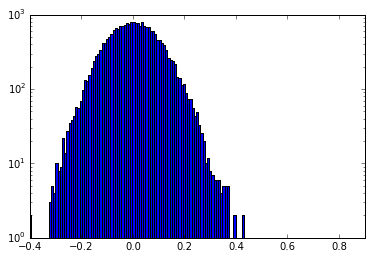

In [8]:
##histogram of prediction accuracy, all voxels
_=plt.hist(ms.val_cc,100)
plt.yscale('log')
plt.ylim([10**0, 10**3])
plt.xlim([-.4, 0.9])

np.sum(map(lambda x: x > 0.2, ms.val_cc))

#### loss histories, all voxels

In [ ]:
_=plt.plot(beh-beh[0,:])


#### view loss history for a few voxels

In [ ]:
_=plt.plot(beh[:,slice(0,-1,1200)]-beh[0,slice(0,-1,1200)])

In [ ]:
##loss in "final_validation_loss" = last point of "best_error_history"
print np.min(beh[:,-2])
print fvl[-2]

#### diff between first and last point of loss history, all voxels

In [ ]:
np.sum(np.nan_to_num(beh[0,:]-np.min(beh,axis=0)))

In [ ]:
_=plt.hist(np.nan_to_num(beh[0,:]-np.min(beh,axis=0)),100)
plt.yscale('log')
plt.xlim([0, 140])

### Step 6: model analysis and validation

#### histogram of rf models selected for each voxel

In [ ]:
_=plt.hist(frf,ms.receptive_fields.G)
plt.xlabel('smaller-->bigger')

#### sum of all selected rfs. 

In [ ]:
plt.imshow(np.sum(ms.receptive_fields.make_rf_stack(64, min_pix_per_radius=1)[frf,:,:], axis=0), cmap='hot')

#### area-wise prediction accuracy

In [12]:
##get position information. need to re-open file
voxel_file = '/media/tnaselar/Data/crcns_datasets/vim-1/EstimatedResponses.mat'
crcns_voxel_data = h5py.File(voxel_file,'r')

vox_position = crcns_voxel_data['voxIdxS1'][0,no_nan]  ##index into a 64 x 64 x 18 volume (matlab-style raveling)

##get the indices for visual areas
roi_indicator = crcns_voxel_data['roiS1'][0, no_nan]
roi_names = ['other', 'v1', 'v2', 'v3', 'v3A', 'v3B', 'v4', 'LO']

crcns_voxel_data.close()

In [15]:
##area-wise prediction accuracy
areawise_accuracy = []
for ii,roi in enumerate(roi_names):
    voxels_in_roi = roi_indicator == ii
    areawise_accuracy.append(np.array(ms.val_cc)[voxels_in_roi])

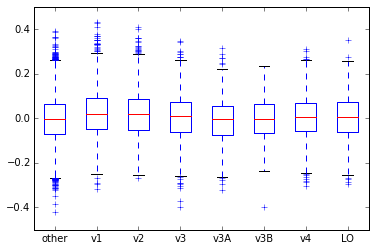

In [16]:
_=plt.boxplot(areawise_accuracy,labels = roi_names)

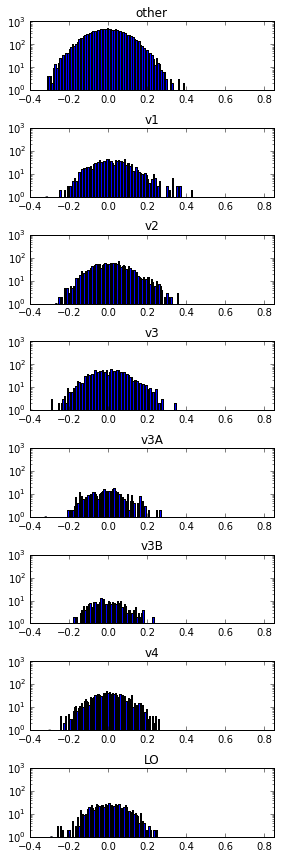

In [17]:
n_rois = len(roi_names)
fig = plt.figure(figsize = (4,12))
for ii,roi in enumerate(roi_names):
    plt.subplot(n_rois,1,ii+1)
    plt.hist(areawise_accuracy[ii],100)
    plt.yscale('log')
    plt.xlim([-0.4, 0.85])
    plt.ylim([0, 10**3])
    plt.title(roi)
plt.tight_layout()  

#### area-wise rf size vs. eccentricity

In [ ]:
## construct data table of rfs--indices will now be voxels
frf_sizes = ms.receptive_fields.rf_table.loc[frf,'deg_per_radius'].values
frf_eccentricities = ms.receptive_fields.rf_table.loc[frf, ['x_deg','y_deg']].apply(lambda row: np.sqrt(row['x_deg']**2+row['y_deg']**2),axis=1).values
named_voxels = [roi_names[int(v)] for v in roi_indicator]

In [ ]:
model_table = pd.DataFrame(data=list(frf_sizes), columns=['roi_size'])
model_table['eccentricity'] = frf_eccentricities
model_table['area'] = named_voxels
model_table['valcc'] = val_cc

model_table

In [ ]:
val_thresh = 0.25
size_means = {}
size_stds = {}
area_eccs = {}
for roi in roi_names:
    area_stats = model_table.loc[(model_table['area']==roi) & (model_table['valcc'] > val_thresh),['roi_size', 'eccentricity']]
    ecc_grp = area_stats.groupby(by='eccentricity')
    size_means[roi] = []
    size_stds[roi] = []
    area_eccs[roi] = []
    for name,grp in ecc_grp:
        area_eccs[roi].append(name)
        size_means[roi].append(grp.roi_size.mean())
        size_stds[roi].append(grp.roi_size.std())
    

In [ ]:
roi_colors = ['black', 'r', 'salmon', 'coral', 'darkslategray', 'teal','orangered', 'indigo' ]
ecc = np.sort(np.unique(model_table['eccentricity']))
line_list = []
fig = plt.figure(figsize=(10,10))
for r,roi in enumerate(roi_names):
    plt.plot(area_eccs[roi],size_means[roi], 'o', color=roi_colors[r])
    p = np.polyfit(area_eccs[roi],size_means[roi],1)
    l, = plt.plot(area_eccs[roi], np.polyval(p,area_eccs[roi]), color=roi_colors[r], label=roi, linewidth=4)
    line_list.append(l)
    
plt.legend(loc='upper left', ncol = 4)    
# plt.axis('equal')
plt.xlim([0,14])
plt.ylim([0,8])


#### layer x area weight distribution

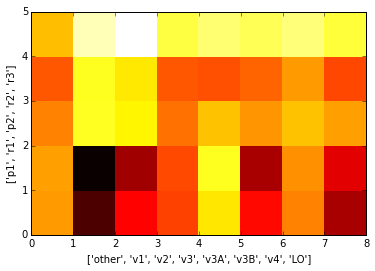

In [29]:
layer_names = ['p1', 'r1', 'p2', 'r2', 'r3']
weights = np.zeros(( len(ms.feature_depth.keys()), len(roi_names),))

for ii,roi in enumerate(roi_names):
    voxels_in_roi = roi_indicator == ii
    layer_cnt = 0
    for layer in layer_names:
        idx = ms.feature_indices[layer]
        weights[layer_cnt,ii] = np.mean(ms.optimal_feature_weights[idx,:][:,voxels_in_roi])
        layer_cnt += 1

plt.pcolor(weights, cmap='hot')
plt.ylabel(layer_names)
plt.xlabel(roi_names)
        

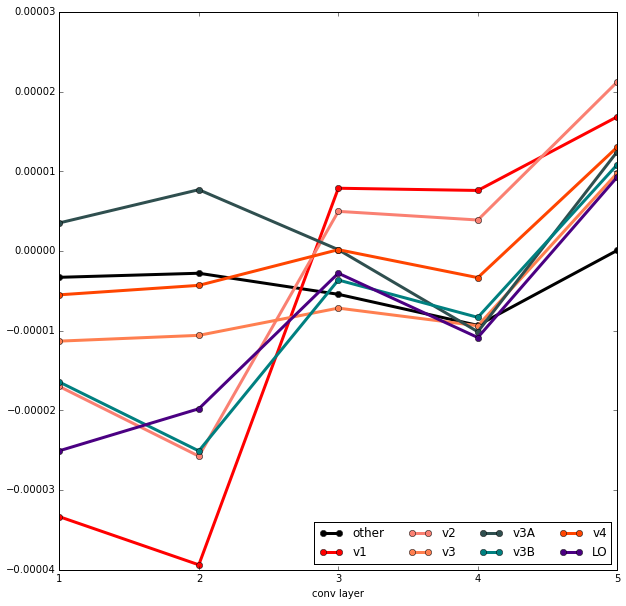

In [30]:
roi_colors = ['black', 'r', 'salmon', 'coral', 'darkslategray', 'teal','orangered', 'indigo' ]
plt.figure(figsize = (10,10))
for ii,roi in enumerate(roi_names):
    _=plt.plot([1,2,3,4,5],weights[:,ii],'o-',label=roi, color = roi_colors[ii], linewidth=3)
plt.legend(loc='lower right', ncol=4)
plt.xticks([1,2,3,4,5])
plt.xlabel('conv layer')